In [78]:
#%%writefile NeuralNetworkModel.py
import numpy as np
import copy

class NeuralNetwork():
    def __init__(self):
        self.layers = []
        self.parameters = {}
        self.cache = []
        self.grads = {}
        self.params = {}
    
    def add(self,units,activation):
        self.layers.append([units,activation])

    def init_weights(self,x_dim):
        np.random.seed(1)
        self.layers.insert(0,[x_dim,'relu'])
        
        L = len(self.layers) -1 

        for l in range(1, L + 1):
            self.parameters['W' + str(l)] = np.random.randn(self.layers[l][0],self.layers[l-1][0]) * np.sqrt(2/self.layers[l-1][0])
            self.parameters['b' + str(l)] = np.zeros((self.layers[l][0],1))



    def relu(self,x):
        return np.maximum(0,x)

    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def relu_backward(self,dA,Z):
        dZ = np.array(dA,copy=True)
        dZ [Z <= 0 ] = 0
        return dZ
    
    def sigmoid_backward(self,dA,Z):
        x = 1 / (1+np.exp(-Z))
        return dA * x *(1-x)

    def forward_propagation(self,X):
        self.cache = []
        L = len(self.parameters) // 2
        
        A = X

        for l in range(1,L):
            a_prev = A
            W = self.parameters[f"W{l}"]
            b = self.parameters[f"b{l}"]
            Z = np.dot(W,a_prev) + b
            
            if self.layers[l][1] == 'relu':
                A = self.relu(Z)
            elif self.layers[l][1] == 'sigmoid':
                A = self.sigmoid(Z)
                
            self.cache.append((a_prev,W,b,Z))

        W = self.parameters[f"W{L}"]
        b = self.parameters[f"b{L}"]
        Z = np.dot(W,A) + b

        if self.layers[L][1] == 'relu':
            A = self.relu(Z)
        elif self.layers[L][1] == 'sigmoid':
            A = self.sigmoid(Z)
            
        self.cache.append((A,W,b,Z))
        return A


    def loss(self,Output,Y):
        m = Y.shape[1]
        if self.layers[-1][1] == 'relu':
            cost = 1/m * np.sum((Y-Output)**2)
            cost = np.squeeze(cost)
        elif self.layers[-1][1] == 'sigmoid':
            cost = -1/m * np.sum(Y*np.log(Output) + (1-Y) * np.log(1-Output))
            cost = np.squeeze(cost)
        return cost


    def compute_grads(self,dZ,A,W):
        m = A.shape[1]
        dA = np.dot(W.T,dZ)
        dW = 1/m * np.dot(dZ,A.T)
        db = 1/m * np.sum(dZ,axis=1,keepdims=True)
        return dA,dW,db

    def backward_propagation(self,Y,A):
        L = len(self.cache)

        Y = Y.reshape(A.shape)
        epsilon = 1e-8
        #dA = - (np.divide(Y,A) - np.divide(1-Y,1-A))
        dA = - (np.divide(Y, A + epsilon) - np.divide(1 - Y, 1 - A + epsilon))

        A,W,b,Z = self.cache[L-1] 
        if self.layers[L-1][1] == 'relu':
            dZ = self.relu_backward(dA,Z)
        elif self.layers[L-1][1] == 'sigmoid':
            dZ = self.sigmoid_backward(dA,Z)

        dA,dW,db = self.compute_grads(dZ,A,W)
        self.grads['dW' + str(L)] = dW
        self.grads['db' + str(L)] = db
        self.grads['dA' + str(L-1)] = dA

        for l in reversed(range(L-1)):
            A,W,b,Z = self.cache[l]
            if self.layers[l][1] == 'relu':
                dZ = self.relu_backward(dA,Z)
            elif self.layers[l][1] == 'sigmoid':
                dZ = self.sigmoid_backward(dA,Z)
    
            dA,dW,db = self.compute_grads(dZ,A,W)
            self.grads['dW' + str(l+1)] = dW
            self.grads['db' + str(l+1)] = db
            self.grads['dA' + str(l)] = dA


    def update_parameters(self,lr):
        self.params = copy.deepcopy(self.parameters)
        L = len(self.parameters) // 2
    
        for l in range(L):
            self.params[f"W{l+1}"] = self.params[f"W{l+1}"] - lr * self.grads[f"dW{l+1}"]
            self.params[f"b{l+1}"] = self.params[f"b{l+1}"] - lr * self.grads[f"db{l+1}"]

        self.parameters = self.params


    def predict(self,X):
        A = self.forward_propagation(X)
        if self.layers[-1][1] == 'relu':
            return A
        elif self.layers[-1][1] == 'sigmoid':
            pred = (A > 0.5).astype(int)
            return pred


    def fit(self,X,Y,epochs=1000,learning_rate=0.001):
        x_dim = X.shape[0]
        self.init_weights(x_dim)

        for i in range(epochs):
            A = self.forward_propagation(X)
            loss = self.loss(A,Y)
            self.backward_propagation(Y,A)
            self.update_parameters(learning_rate)

            if i %100 ==0:
                print(f"Epochs : {i} , loss = {loss}")


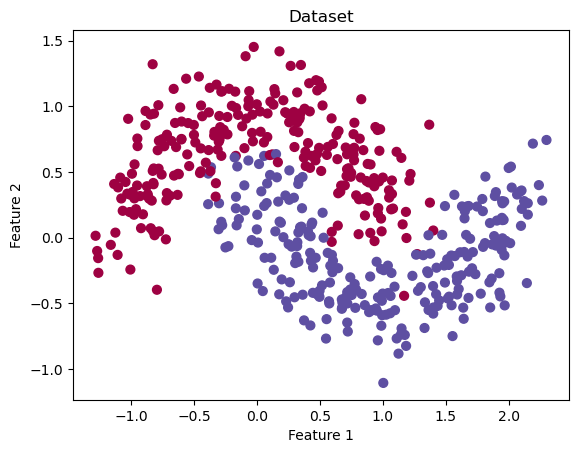

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate a dataset with two interleaving half circles
X, Y = make_moons(n_samples=500, noise=0.2, random_state=0)
Y = Y.reshape((1, Y.shape[0]))  # reshape Y to (1, m)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)
plt.title("Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [82]:
X_T = X.T

model = NeuralNetwork()
model.add(32,"relu")
model.add(32,"relu")
model.add(1,"sigmoid")

model.fit(X_T,Y,epochs=3000,learning_rate=0.02)

Epochs : 0 , loss = 0.6762967882909896
Epochs : 100 , loss = 0.37451984193592835
Epochs : 200 , loss = 0.3395989437567383
Epochs : 300 , loss = 0.3251009771659734
Epochs : 400 , loss = 0.31748374517780803
Epochs : 500 , loss = 0.3132558779040053
Epochs : 600 , loss = 0.3126286280368463
Epochs : 700 , loss = 0.31344310572179795
Epochs : 800 , loss = 0.3153030987982271
Epochs : 900 , loss = 0.31731985503493004
Epochs : 1000 , loss = 0.31890695094716415
Epochs : 1100 , loss = 0.32031831191654286
Epochs : 1200 , loss = 0.32110234448959074
Epochs : 1300 , loss = 0.3209120075339099
Epochs : 1400 , loss = 0.31919522964994723
Epochs : 1500 , loss = 0.31554244974069495
Epochs : 1600 , loss = 0.3088151752285706
Epochs : 1700 , loss = 0.3017080149626947
Epochs : 1800 , loss = 0.29250513916185367
Epochs : 1900 , loss = 0.2812771324673764
Epochs : 2000 , loss = 0.2691191808948701
Epochs : 2100 , loss = 0.2564435059022533
Epochs : 2200 , loss = 0.26055123650649714
Epochs : 2300 , loss = 0.2623148008

C:\Users\janma\AppData\Local\Temp\ipykernel_10532\3369132591.py:81: RuntimeWarning: divide by zero encountered in log
  cost = -1/m * np.sum(Y*np.log(Output) + (1-Y) * np.log(1-Output))
C:\Users\janma\AppData\Local\Temp\ipykernel_10532\3369132591.py:81: RuntimeWarning: invalid value encountered in multiply
  cost = -1/m * np.sum(Y*np.log(Output) + (1-Y) * np.log(1-Output))


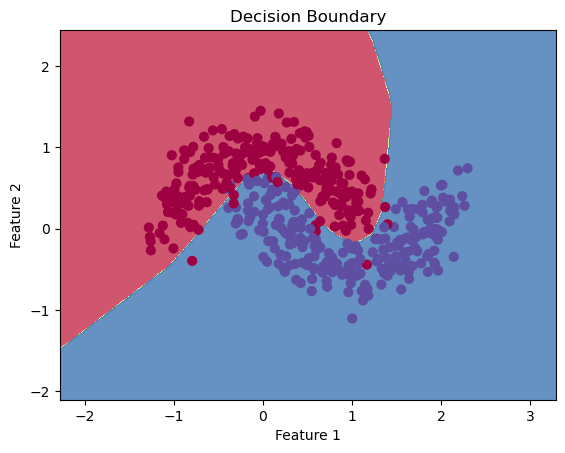

In [83]:
def plot_decision_boundary(model, X, Y):
    # Set min and max values and give some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, Y)